In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession \
    .builder \
    .appName("how to read csv file") \
    .getOrCreate()

## Importanción de datos

In [3]:
mes_datos="2022-1"

In [4]:
! wget https://transparenciachc.blob.core.windows.net/oc-da/{mes_datos}.zip

--2022-05-27 14:56:40--  https://transparenciachc.blob.core.windows.net/oc-da/2022-1.zip
Resolving transparenciachc.blob.core.windows.net (transparenciachc.blob.core.windows.net)... 52.226.8.148
Connecting to transparenciachc.blob.core.windows.net (transparenciachc.blob.core.windows.net)|52.226.8.148|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59051167 (56M) [application/zip]
Saving to: ‘2022-1.zip.1’

2022-1.zip.1        100%[===================>]  56.32M  5.72MB/s    in 12s     

2022-05-27 14:56:54 (4.54 MB/s) - ‘2022-1.zip.1’ saved [59051167/59051167]



In [5]:
! ls

2022-1-corregido.csv  MLIB-ALS.ipynb
2022-1.csv	      Obligatorio_Francisco_Rossi_Ivan_Monjardin8.ipynb
2022-1.zip	      Prueba
2022-1.zip.1	      work
datasets


In [8]:
! unzip -f -o {mes_datos}.zip 

Archive:  2022-1.zip


In [9]:
! ls

2022-1.csv  MLIB-ALS.ipynb				       work
2022-1.zip  Obligatorio_Francisco_Rossi_Ivan_Monjardin8.ipynb
datasets    Prueba


In [10]:
# rm  {mes_datos}.zip  

In [11]:
! ls

2022-1.csv  MLIB-ALS.ipynb				       work
2022-1.zip  Obligatorio_Francisco_Rossi_Ivan_Monjardin8.ipynb
datasets    Prueba


## Limpieza archivo CVS

Algunos valores incluyen "Enters" adentro de los valores, por lo tanto vamos a eliminarlos para que se lea bien el csv

In [6]:
def valid_csv_line (line, quote_char, col_quanity):
    num_of_col = 1
    is_inside_quotes = False
    for char in line:
        if char == quote_char:
            is_inside_quotes = not is_inside_quotes
        else:
            if char == ";" and (not is_inside_quotes):
                num_of_col = num_of_col + 1
                if num_of_col > col_quanity:
                    return False
                
    return num_of_col == col_quanity
            

In [13]:
# def valid_csv_line (line, quote_char, col_quantity):
#     return line.count(';') >= (col_quantity -1 )

Arregla filas incorrectas con enters por la mitad

In [7]:
archivoInicial = open(f'{mes_datos}.csv', 'r', encoding='ISO-8859-1')
import os

if os.path.exists(f'{mes_datos}-corregido.csv'):
  os.remove(f'{mes_datos}-corregido.csv')

archivoFinal = open(f'{mes_datos}-corregido.csv', 'a+', encoding='ISO-8859-1' )
Lines = archivoInicial.readlines()

correct_new_line = ""
for line in Lines:
    correct_new_line = correct_new_line + line.rstrip()
    
    if valid_csv_line(correct_new_line,"\"",78):
        archivoFinal.writelines(correct_new_line + '\n')

        correct_new_line = ""

In [8]:
archivoInicial.close()
archivoFinal.close()

In [9]:
df_original_corregido = spark.read.format("csv").options(header=True, delimiter=';',encoding="ISO-8859-1").csv('2022-1-corregido.csv')

In [10]:
df_original_corregido.show(10,vertical=True)

-RECORD 0------------------------------------------
 ID                         | 41200292             
 Codigo                     | 653-4-SE20           
 Link                       | http://www.mercad... 
 Nombre                     | FTO DON CARLOS, C... 
 Descripcion/Obervaciones   | SERVICIOS DE F.T.... 
 Tipo                       | SE                   
 ProcedenciaOC              | Proveniente de li... 
 EsTratoDirecto             | No                   
 EsCompraAgil               | No                   
 CodigoTipo                 | 8                    
 CodigoAbreviadoTipoOC      | SE                   
 DescripcionTipoOC          | Sin emisión autom... 
 codigoEstado               | 6                    
 Estado                     | Aceptada             
 codigoEstadoProveedor      | 4                    
 EstadoProveedor            | Aceptada             
 FechaCreacion              | 2020-01-08           
 FechaEnvio                 | 2022-01-04           
 FechaSolici

## Ingeniería de Atributos

### Columnas Relevantes
Eliminamos las columnas que no sean relevanes para nuestro analisis, dejando solo las que sí podemos llegar a utilizar 

In [11]:
df_original = df_original_corregido

In [12]:
df_original.columns

['ID',
 'Codigo',
 'Link',
 'Nombre',
 'Descripcion/Obervaciones',
 'Tipo',
 'ProcedenciaOC',
 'EsTratoDirecto',
 'EsCompraAgil',
 'CodigoTipo',
 'CodigoAbreviadoTipoOC',
 'DescripcionTipoOC',
 'codigoEstado',
 'Estado',
 'codigoEstadoProveedor',
 'EstadoProveedor',
 'FechaCreacion',
 'FechaEnvio',
 'FechaSolicitudCancelacion',
 'fechaUltimaModificacion',
 'FechaAceptacion',
 'FechaCancelacion',
 'tieneItems',
 'PromedioCalificacion',
 'CantidadEvaluacion',
 'MontoTotalOC',
 'TipoMonedaOC',
 'MontoTotalOC_PesosChilenos',
 'Impuestos',
 'TipoImpuesto',
 'Descuentos',
 'Cargos',
 'TotalNetoOC',
 'CodigoUnidadCompra',
 'RutUnidadCompra',
 'UnidadCompra',
 'CodigoOrganismoPublico',
 'OrganismoPublico',
 'sector',
 'ActividadComprador',
 'CiudadUnidadCompra',
 'RegionUnidadCompra',
 'PaisUnidadCompra',
 'CodigoSucursal',
 'RutSucursal',
 'Sucursal',
 'CodigoProveedor',
 'NombreProveedor',
 'ActividadProveedor',
 'ComunaProveedor',
 'RegionProveedor',
 'PaisProveedor',
 'Financiamiento',
 'P

In [13]:
df_columnas_relevantes = df_original[
    ['Estado',
 'FechaCreacion',
 'FechaAceptacion',
 'MontoTotalOC_PesosChilenos',
 'OrganismoPublico',
 'sector',
 'CiudadUnidadCompra',
 'RegionUnidadCompra',
 'PaisProveedor',
 'IDItem',
 'RubroN1',
 'RubroN2',
 'RubroN3',
 'cantidad',
 'UnidadMedida']
]

In [14]:
df_columnas_relevantes.show(15,vertical=True)

-RECORD 0------------------------------------------
 Estado                     | Aceptada             
 FechaCreacion              | 2020-01-08           
 FechaAceptacion            | 2022-01-05           
 MontoTotalOC_PesosChilenos | 55699353,7632        
 OrganismoPublico           | SERVICIO DE VIVIE... 
 sector                     | Obras Públicas       
 CiudadUnidadCompra         | Talca                
 RegionUnidadCompra         | Región del Maule     
 PaisProveedor              | null                 
 IDItem                     | 108832323            
 RubroN1                    | Servicios profesi... 
 RubroN2                    | Consultorías o as... 
 RubroN3                    | Gestión de proyectos 
 cantidad                   | 1                    
 UnidadMedida               | Global               
-RECORD 1------------------------------------------
 Estado                     | Aceptada             
 FechaCreacion              | 2020-01-20           
 FechaAcepta

In [15]:
df_columnas_relevantes.count()

281750

#### Eliminar filas que no cuentas con un Estado válido. Deberían ser solo 5 posibles valores

In [16]:
df_columnas_relevantes.select("Estado").distinct().show(vertical=True)

-RECORD 0----------------------
 Estado | Compra Ágil          
-RECORD 1----------------------
 Estado | Sin emisión autom... 
-RECORD 2----------------------
 Estado | Convenio Marco       
-RECORD 3----------------------
 Estado | 8                    
-RECORD 4----------------------
 Estado | 6                    
-RECORD 5----------------------
 Estado | CM                   
-RECORD 6----------------------
 Estado | Cancelacion solic... 
-RECORD 7----------------------
 Estado | En proceso           
-RECORD 8----------------------
 Estado | Recepcion Conforme   
-RECORD 9----------------------
 Estado | Enviada a proveedor  
-RECORD 10---------------------
 Estado | 12                   
-RECORD 11---------------------
 Estado | Aceptada             



In [17]:
estados_validos = ["Aceptada", "En proceso","Cancelacion solicitada", "Enviada a proveedor", "Recepcion Conforme"] 

In [18]:
df_estados_validos =df_columnas_relevantes.filter(df_columnas_relevantes.Estado.isin(estados_validos))
df_estados_validos.select("Estado").distinct().show(vertical=True)

-RECORD 0----------------------
 Estado | Cancelacion solic... 
-RECORD 1----------------------
 Estado | En proceso           
-RECORD 2----------------------
 Estado | Recepcion Conforme   
-RECORD 3----------------------
 Estado | Enviada a proveedor  
-RECORD 4----------------------
 Estado | Aceptada             



### Analisis de atributos


In [31]:
df = df_estados_validos

In [32]:
df.printSchema()

root
 |-- Estado: string (nullable = true)
 |-- FechaCreacion: string (nullable = true)
 |-- FechaAceptacion: string (nullable = true)
 |-- MontoTotalOC_PesosChilenos: string (nullable = true)
 |-- OrganismoPublico: string (nullable = true)
 |-- sector: string (nullable = true)
 |-- CiudadUnidadCompra: string (nullable = true)
 |-- RegionUnidadCompra: string (nullable = true)
 |-- PaisProveedor: string (nullable = true)
 |-- IDItem: string (nullable = true)
 |-- RubroN1: string (nullable = true)
 |-- RubroN2: string (nullable = true)
 |-- RubroN3: string (nullable = true)
 |-- cantidad: string (nullable = true)
 |-- UnidadMedida: string (nullable = true)



In [33]:
from pyspark.sql.functions import isnan, when, count, col
df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show(vertical=True)

-RECORD 0---------------------------
 Estado                     | 0     
 FechaCreacion              | 0     
 FechaAceptacion            | 0     
 MontoTotalOC_PesosChilenos | 0     
 OrganismoPublico           | 0     
 sector                     | 0     
 CiudadUnidadCompra         | 27    
 RegionUnidadCompra         | 0     
 PaisProveedor              | 21327 
 IDItem                     | 0     
 RubroN1                    | 0     
 RubroN2                    | 0     
 RubroN3                    | 0     
 cantidad                   | 4     
 UnidadMedida               | 0     



In [34]:
df.where(df.PaisProveedor.isNull()).count()

21327

In [35]:
df.count()

281650

##### De las 281895 originales, se eliminaron aproximadamente 245 líneas

Convertimos las fechas a formato fecha

In [71]:
from datetime import datetime
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType, IntegerType, DateType, StringType

In [24]:
# # UDF to process the date column
# toDate = udf(lambda x: datetime.strptime(x, '%Y-%m-%d'), DateType())

In [25]:
# df = df \
#     .withColumn('FechaCreacion', toDate(col('FechaCreacion'))) \
#     .withColumn('FechaAceptacion', toDate(col('FechaAceptacion'))) 

In [37]:
df['FechaCreacion','FechaAceptacion'].printSchema()

root
 |-- FechaCreacion: string (nullable = true)
 |-- FechaAceptacion: string (nullable = true)



Convertimos los valores númericos a sus repectivos tipos

In [38]:
df = df \
    .withColumn('MontoTotalOC_PesosChilenos', col('MontoTotalOC_PesosChilenos').cast(DoubleType())) \
    .withColumn('IDItem', col('IDItem').cast(IntegerType())) \
    .withColumn('cantidad', col('cantidad').cast(DoubleType())) 

In [39]:
df['MontoTotalOC_PesosChilenos','IDItem', 'cantidad'].printSchema()

root
 |-- MontoTotalOC_PesosChilenos: double (nullable = true)
 |-- IDItem: integer (nullable = true)
 |-- cantidad: double (nullable = true)



In [40]:
df.printSchema()

root
 |-- Estado: string (nullable = true)
 |-- FechaCreacion: string (nullable = true)
 |-- FechaAceptacion: string (nullable = true)
 |-- MontoTotalOC_PesosChilenos: double (nullable = true)
 |-- OrganismoPublico: string (nullable = true)
 |-- sector: string (nullable = true)
 |-- CiudadUnidadCompra: string (nullable = true)
 |-- RegionUnidadCompra: string (nullable = true)
 |-- PaisProveedor: string (nullable = true)
 |-- IDItem: integer (nullable = true)
 |-- RubroN1: string (nullable = true)
 |-- RubroN2: string (nullable = true)
 |-- RubroN3: string (nullable = true)
 |-- cantidad: double (nullable = true)
 |-- UnidadMedida: string (nullable = true)



### Convertimos a Pandas

In [73]:
import sys
import seaborn as sns 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [74]:
dfp = df.toPandas() 

In [75]:
dfp.head(10) 

,Estado,FechaCreacion,FechaAceptacion,MontoTotalOC_PesosChilenos,OrganismoPublico,sector,CiudadUnidadCompra,RegionUnidadCompra,PaisProveedor,IDItem,RubroN1,RubroN2,RubroN3,cantidad,UnidadMedida
0,Aceptada,2020-01-08,2022-01-05,NaN,SERVICIO DE VIVIENDA Y URBANIZACION VII REGION,Obras Públicas,Talca,Región del Maule,None,108832323,"Servicios profesionales, administrativos y con...",Consultorías o asesorías en gestión empresarial,Gestión de proyectos,1.0,Global
1,Aceptada,2020-01-20,2022-05-02,NaN,I MUNICIPALIDAD DE PENCAHUE,Municipalidades,Pencahue,Región del Maule,Chile,109034639,Servicios de limpieza industrial,Eliminación y tratamiento de desechos,Eliminación de residuos no peligrosos,4800.0,Unidad
2,Aceptada,2020-08-05,2022-01-10,NaN,HOSPITAL BASE OSORNO,Salud,Osorno,Región de los Lagos,Chile,112151073,"Salud, servicios sanitarios y alimentación",Servicios para el cuidado de la salud de las p...,Ambulatorios,1.0,Unidad
3,Aceptada,2020-08-05,2022-01-10,11040465.0,HOSPITAL BASE OSORNO,Salud,Osorno,Región de los Lagos,Chile,112151076,"Salud, servicios sanitarios y alimentación",Servicios para el cuidado de la salud de las p...,Ambulatorios,1.0,Unidad
4,Aceptada,2020-08-05,2022-01-10,5953451.0,HOSPITAL BASE OSORNO,Salud,Osorno,Región de los Lagos,Chile,112153879,"Salud, servicios sanitarios y alimentación",Servicios para el cuidado de la salud de las p...,Ambulatorios,1.0,Unidad
5,Aceptada,2020-08-05,2022-01-10,2650850.0,HOSPITAL BASE OSORNO,Salud,Osorno,Región de los Lagos,Chile,112153884,"Salud, servicios sanitarios y alimentación",Servicios para el cuidado de la salud de las p...,Ambulatorios,1.0,Unidad
6,Aceptada,2020-08-05,2022-01-10,NaN,HOSPITAL BASE OSORNO,Salud,Osorno,Región de los Lagos,Chile,112153887,"Salud, servicios sanitarios y alimentación",Servicios para el cuidado de la salud de las p...,Ambulatorios,1.0,Unidad
7,Aceptada,2020-08-05,2022-01-10,2852290.0,HOSPITAL BASE OSORNO,Salud,Osorno,Región de los Lagos,Chile,112153889,"Salud, servicios sanitarios y alimentación",Servicios para el cuidado de la salud de las p...,Ambulatorios,1.0,Unidad
8,Aceptada,2020-08-05,2022-01-10,NaN,HOSPITAL BASE OSORNO,Salud,Osorno,Región de los Lagos,Chile,112153914,"Salud, servicios sanitarios y alimentación",Servicios para el cuidado de la salud de las p...,Ambulatorios,1.0,Unidad
9,Aceptada,2020-08-05,2022-01-10,7645468.0,HOSPITAL BASE OSORNO,Salud,Osorno,Región de los Lagos,Chile,112153965,"Salud, servicios sanitarios y alimentación",Servicios para el cuidado de la salud de las p...,Ambulatorios,1.0,Unidad


In [77]:
df_category = dfp
for col in df_category.columns:
    if dict(df.dtypes)[col] == 'string':
        df_category[col] = df_category[col].astype('category')
        df_category[col] = df_category[col].cat.codes

In [78]:
dfpandas = df_category

In [79]:
dfpandas.describe() #vemos la descripción estadística de los datos numéricos

,Estado,FechaCreacion,FechaAceptacion,MontoTotalOC_PesosChilenos,OrganismoPublico,sector,CiudadUnidadCompra,RegionUnidadCompra,PaisProveedor,IDItem,RubroN1,RubroN2,RubroN3,cantidad,UnidadMedida
count,281650.000000,281650.000000,281650.000000,1.566460e+05,281650.000000,281650.000000,281650.000000,281650.000000,281650.000000,2.816500e+05,281650.000000,281650.000000,281650.000000,2.804110e+05,281650.000000
mean,2.582084,198.285514,25.416861,5.167730e+06,416.921672,3.851653,206.681900,8.331500,4.432516,1.203407e+08,22.852459,201.071070,906.515896,3.896093e+03,137.732239
std,1.892220,15.441157,25.215457,1.360332e+08,250.869104,2.202075,106.624878,4.957832,1.607896,2.664951e+05,16.058370,82.508178,458.343005,7.225702e+05,23.207524
min,0.000000,0.000000,0.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,1.088323e+08,0.000000,0.000000,0.000000,1.000000e+00,0.000000
25%,0.000000,192.000000,12.000000,4.366058e+05,185.000000,3.000000,119.000000,2.000000,5.000000,1.202711e+08,11.000000,153.000000,497.000000,1.000000e+00,120.000000
50%,4.000000,199.000000,20.000000,1.094800e+06,400.000000,3.000000,217.000000,10.000000,5.000000,1.203729e+08,18.000000,211.000000,1024.000000,9.000000e+00,153.000000
75%,4.000000,209.000000,27.000000,2.927400e+06,650.000000,6.000000,317.000000,13.000000,5.000000,1.204727e+08,33.000000,250.000000,1235.000000,5.000000e+01,153.000000
max,4.000000,216.000000,134.000000,4.292461e+10,854.000000,6.000000,362.000000,16.000000,14.000000,1.205894e+08,57.000000,329.000000,1623.000000,3.294000e+08,156.000000


<AxesSubplot:>

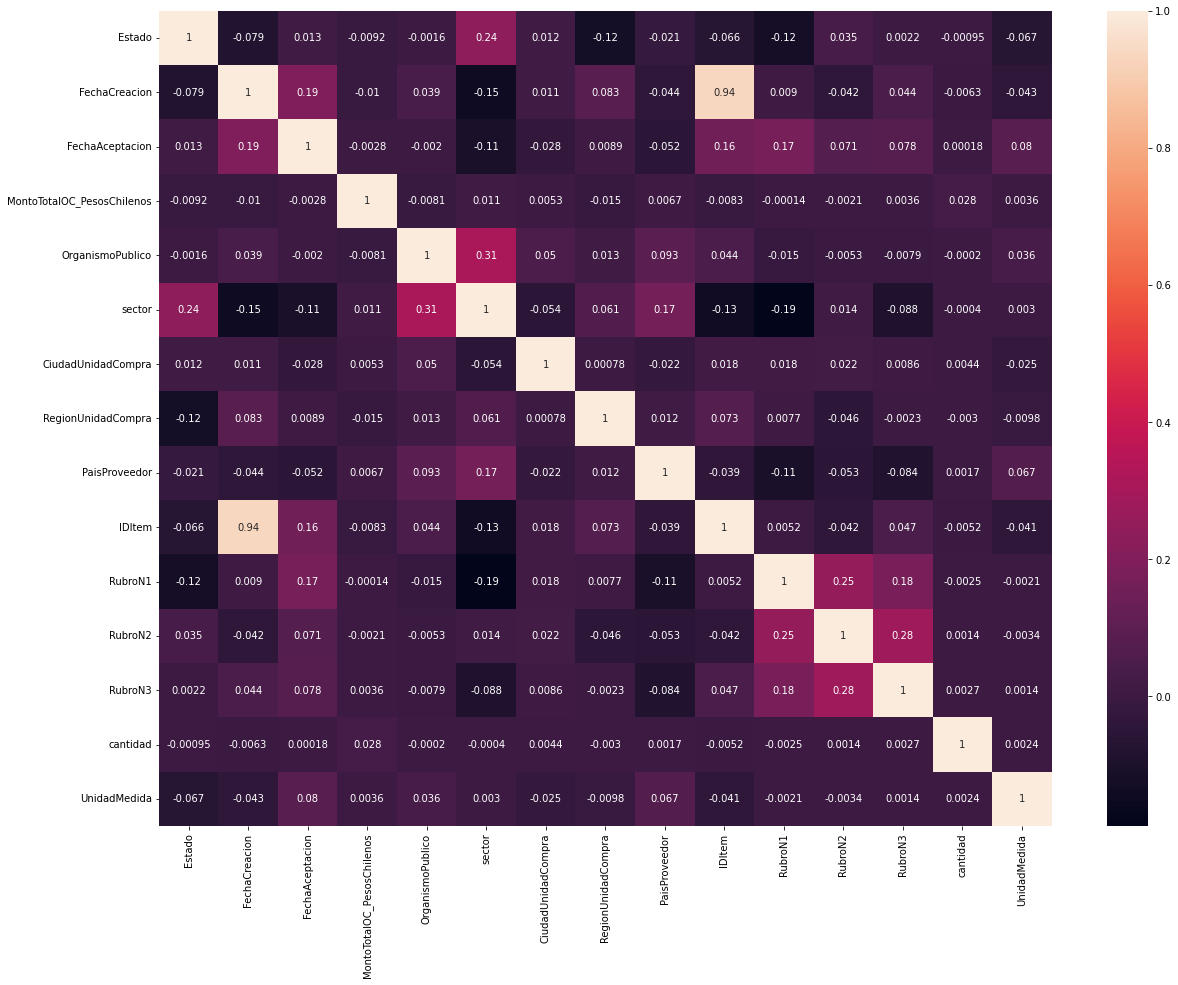

In [82]:
corr = dfpandas.corr()
plt.subplots(figsize=(20,15))
sns.heatmap(corr,  annot = True)

In [81]:
! pip install https://github.com/ydataai/pandas-profiling/archive/master.zip

  Using cached https://github.com/ydataai/pandas-profiling/archive/master.zip
  Stored in directory: /tmp/pip-ephem-wheel-cache-tmpiib_k/wheels/22/22/dd/ac60dcd5f27011638d0db39a73f81f15abc174111bc90426b1
Successfully built pandas-profiling


In [83]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from ipywidgets import FloatProgress
import matplotlib.pyplot as plt
%matplotlib inline

profile = ProfileReport(dfpandas, title="Compras del estado Chileno", minimal = True)

In [86]:
profile.to_file("ComprasChile.html")

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]